# YOLOv8 + ByteTrack

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Перед тем как начать

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
import cv2
import matplotlib.pyplot as plt

class VideoProcessor:
    def __init__(self, video_path, ):
        self.video_path = video_path
        self.video = cv2.VideoCapture(video_path)
        self.width = int(self.video.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.height = int(self.video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    def get_frame_by_order(self, frame_number):
        self.video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = self.video.read()
        if ret:return frame
        else:return None

    def get_width_height(self):
        return self.width, self.height



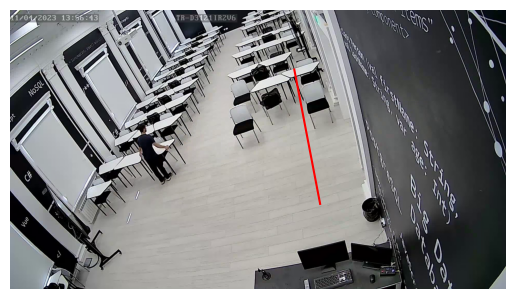

In [ ]:
video_path = '/content/test.avi'


processor = VideoProcessor(video_path)

frame_number = 1320

frame = processor.get_frame_by_order(frame_number)

coords = [[1100, 230],[1200, 750]]

if frame is not None:
    fig, ax = plt.subplots(frameon=False)
    ax.axis('off')
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    x1, y1 = coords[0]
    x2, y2 = coords[1]

    # Отобразить изображение с линией
    plt.plot([x1, x2], [y1, y2], color='r')


    plt.show()



In [ ]:
!nvidia-smi

Thu Jan  4 09:10:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Скачать видео

In [ ]:
%cd {HOME}

/content


## Установка YOLOv8

In [ ]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.234 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


## Установка ByteTrack

[ByteTrack](https://github.com/ifzhang/ByteTrack) is great tracker but a bit poorly packaged. We need to jump through some fire hoops to make it work in tandem with [YOLOv8](https://github.com/ultralytics/ultralytics).

In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Установка Roboflow Supervision

In [ ]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator

In [ ]:
from typing import List
import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

## Загрузка модели YOLOv8

In [ ]:
!cd ../

In [ ]:
# settings
MODEL = "/content/best1280.pt"

In [ ]:
SOURCE_VIDEO_PATH = "/content/test.avi"

In [ ]:
!pwd

/content/ByteTrack


In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

WARNING ⚠️ /content/best1280.pt appears to require 'dill', which is not in ultralytics requirements.
AutoInstall will run now for 'dill' but this feature will be removed in the future.
Recommend fixes are to train a new model using the latest 'ultralytics' package or to run a command with an official YOLOv8 model, i.e. 'yolo predict model=yolov8n.pt'
requirements: Ultralytics requirement ['dill'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.9 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 6.7s, installed 1 package: ['dill']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

Model summary (fused): 168 layers, 3007208 parameters, 0 gradients, 8.1 GFLOPs


## Прогнозирование и отображение одиночного кадра

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [0, 1, 2, 3, 4, 5, 6, 7]

CLASS_ID_BY_NAME = {
    'chair' : 0,
    'person' : 1,
    'interactive whiteboard' : 2,
    'keyboard' : 3,
    'laptop' : 4,
    'monitor' : 5,
    'pc' : 6,
    'table' : 7,
}


WARNING ⚠️ NMS time limit 0.550s exceeded
0: 736x1280 1 chair, 3 persons, 2 monitors, 7 tables, 101.6ms
Speed: 26.3ms preprocess, 101.6ms inference, 726.1ms postprocess per image at shape (1, 3, 736, 1280)


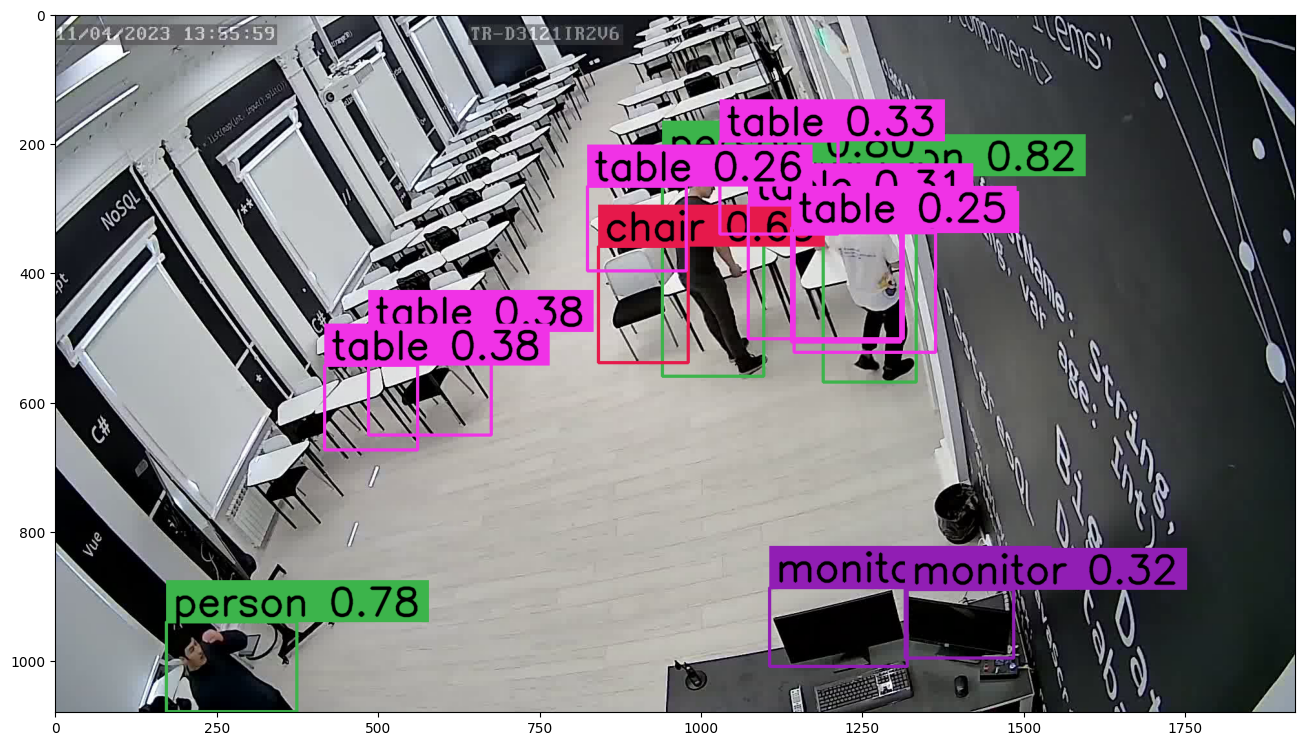

In [ ]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

## Classificator

## Прогнозирование и разметка видеоролика

In [ ]:
from typing import Dict
import cv2
import numpy as np
from supervision.draw.color import Color
from supervision.geometry.dataclasses import Point, Rect, Vector
from supervision.tools.detections import Detections

class CustomLineCounter():
  def __init__(self, start: Point, end: Point, classes: List):
    self.vector = Vector(start=start, end=end)
    self.tracker_state: Dict[str, bool] = {}
    self.result_dict = {int(class_id): {"in_count": int(0), "out_count": int(0)} for class_id in classes}

  def update(self, detections: Detections):

    for id in detections.class_id:
      mask = np.array([class_id in [int(id)] for class_id in detections.class_id], dtype=bool)
      filtereddet = detections.filter(mask=mask, inplace=False)

      for xyxy, confidence, class_id, tracker_id in filtereddet:
        # handle detections with no tracker_id
        if tracker_id is None:
          continue

        # we check if all four anchors of bbox are on the same side of vector
        x1, y1, x2, y2 = xyxy
        anchors = [
          Point(x=x1, y=y1),
          Point(x=x1, y=y2),
          Point(x=x2, y=y1),
          Point(x=x2, y=y2),]
        triggers = [self.vector.is_in(point=anchor) for anchor in anchors]

        # detection is partially in and partially out
        if len(set(triggers)) == 2:
          continue

        tracker_state = triggers[0]
        # handle new detection
        if tracker_id not in self.tracker_state:
          self.tracker_state[tracker_id] = tracker_state
          continue

        # handle detection on the same side of the line
        if self.tracker_state.get(tracker_id) == tracker_state:
          continue

        self.tracker_state[tracker_id] = tracker_state
        if tracker_state:
          self.result_dict[int(id)]['in_count'] += 1
        else:
          self.result_dict[int(id)]['out_count'] += 1


In [ ]:
class CustomLineCounterAnnotator:
    def __init__(
        self,
        thickness: float = 2,
        color: Color = Color.white(),
        text_thickness: float = 2,
        text_color: Color = Color.black(),
        text_scale: float = 0.5,
        text_offset: float = 1.5,
        text_padding: int = 10,
        class_name_dict = {},
        video_info = []
    ):

        self.thickness: float = thickness
        self.color: Color = color
        self.text_thickness: float = text_thickness
        self.text_color: Color = text_color
        self.text_scale: float = text_scale
        self.text_offset: float = text_offset
        self.text_padding: int = text_padding
        self.class_name_dict = class_name_dict
        self.video_info = video_info

    def annotate(self, frame: np.ndarray, line_counter: LineCounter) -> np.ndarray:

        cv2.line(
            frame,
            line_counter.vector.start.as_xy_int_tuple(),
            line_counter.vector.end.as_xy_int_tuple(),
            self.color.as_bgr(),
            self.thickness,
            lineType=cv2.LINE_AA,
            shift=0,
        )
        cv2.circle(
            frame,
            line_counter.vector.start.as_xy_int_tuple(),
            radius=5,
            color=self.text_color.as_bgr(),
            thickness=-1,
            lineType=cv2.LINE_AA,
        )
        cv2.circle(
            frame,
            line_counter.vector.end.as_xy_int_tuple(),
            radius=5,
            color=self.text_color.as_bgr(),
            thickness=-1,
            lineType=cv2.LINE_AA,
        )


        report = ""
        for key in line_counter.result_dict:
            class_name = CLASS_NAMES_DICT[key]
            in_count = line_counter.result_dict[key]['in_count']
            out_count = line_counter.result_dict[key]['out_count']
            report += f" | {class_name}: in {in_count} out {out_count}"
        report += ' |'

        (report_width, report_height), _ = cv2.getTextSize(
            report, cv2.FONT_HERSHEY_SIMPLEX, self.text_scale, self.text_thickness
        )

        report_x = int(
            ((self.video_info.width) - report_width)
            / 2
        )
        report_y = int(
            (150 + report_height)
            / 2
            - self.text_offset * report_height
        )


        report_background_rect = Rect(
            x=report_x,
            y=report_y - report_height,
            width=report_width,
            height=report_height,
        ).pad(padding=self.text_padding)


        cv2.rectangle(
            frame,
            report_background_rect.top_left.as_xy_int_tuple(),
            report_background_rect.bottom_right.as_xy_int_tuple(),
            self.color.as_bgr(),
            -1,
        )


        cv2.putText(
            frame,
            report,
            (report_x, report_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            self.text_scale,
            self.text_color.as_bgr(),
            self.text_thickness,
            cv2.LINE_AA,
        )


In [ ]:
# settings

LINE_START = Point(coords[1][0],coords[1][1])
LINE_END = Point(coords[0][0],coords[0][1])

TARGET_VIDEO_PATH = f"{HOME}/result.mp4"

In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=30, total_frames=1817)

In [ ]:
from tqdm.notebook import tqdm

# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = CustomLineCounter(start=LINE_START, end=LINE_END, classes = CLASS_ID)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
#line_annotator = CustomLineCounterAnnotator(thickness=4, text_thickness=1, text_scale=0.5, class_name_dict = CLASS_NAMES_DICT, video_info = video_info)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int))

        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape)

        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)

        detections.tracker_id = np.array(tracker_id)

        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"id{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections]
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

        line_counter.update(detections=detections)
        line_annotator.annotate(frame=frame, line_counter=line_counter)


        sink.write_frame(frame)
print(line_counter.result_dict)

  0%|          | 0/1817 [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
Speed: 7.7ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 chair, 1 person, 2 monitors, 7 tables, 12.8ms
Speed: 7.1ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 chair, 1 person, 2 monitors, 8 tables, 18.6ms
Speed: 9.1ms preprocess, 18.6ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 2 chairs, 1 person, 2 monitors, 6 tables, 12.8ms
Speed: 7.0ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 2 chairs, 1 person, 2 monitors, 6 tables, 13.1ms
Speed: 7.0ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 2 chairs, 1 person, 2 monitors, 6 tables, 12.8ms
Speed: 7.6ms preprocess, 12.8ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 2 chairs, 1 person, 2 m